1. Import Library

In [ ]:
# Data Processing
import pandas as pd
import numpy as np
import os
import warnings
import glob

import kagglehub

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering & preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score


# Date and Warning Handling
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 200)
sns.set(style='whitegrid')

#import model
!pip install -q skl2onnx onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import json

2. Load Dataset

In [ ]:
warnings.filterwarnings("ignore")
#download dataset
dataset_path = kagglehub.dataset_download("nabihazahid/ecommerce-dataset-for-sql-analysis")

print("Path ke file dataset:", dataset_path)

csv_files = glob.glob(os.path.join(dataset_path, "*.csv"))
print("Daftar file CSV yang ditemukan:")
for f in csv_files:
    print("-", os.path.basename(f))

if len(csv_files) == 1:
    df = pd.read_csv(csv_files[0])
    display(df.head())

Using Colab cache for faster access to the 'ecommerce-dataset-for-sql-analysis' dataset.
Path ke file dataset: /kaggle/input/ecommerce-dataset-for-sql-analysis
Daftar file CSV yang ditemukan:
- ecommerce_dataset_10000.csv


,customer_id,first_name,last_name,gender,age_group,signup_date,country,product_id,product_name,category,quantity,unit_price,order_id,order_date,order_status,payment_method,rating,review_text,review_id,review_date
0,CUST2353,Erica,Oliver,Female,Teenagers,2022-06-29,Canada,PROD108,Fitbit Versa 3,Electronics,3,229,ORD10000,2023-07-13,Pending,Credit Card,2,good,REV20000,2025-06-06
1,CUST4463,Christopher,White,Male,Adults,2023-08-24,China,PROD103,Levi's Jeans,Apparel,4,59,ORD10001,2024-08-12,Pending,PayPal,2,average,REV20001,2023-08-05
2,CUST4512,Spencer,Foster,Male,Senior,2023-07-18,Germany,PROD111,Lego Star Wars Set,Toys,2,59,ORD10002,2024-08-04,Delivered,Cash on Delivery,5,good,REV20002,2023-01-03
3,CUST5711,Jessica,Harris,Male,Teenagers,2025-08-22,France,PROD107,Dyson Vacuum,Home & Kitchen,4,399,ORD10003,2025-05-23,Delivered,Cash on Delivery,2,very good,REV20003,2023-03-14
4,CUST1296,Amy,Johnson,Female,Teenagers,2021-03-23,Brazil,PROD105,Adidas Running Shoes,Apparel,1,110,ORD10004,2023-07-02,Returned,Cash on Delivery,1,very good,REV20004,2023-10-18


In [ ]:
print("Initial dataframe info:")
df.info()
print("\nMissing values per column:\n", df.isnull().sum())

# 1. Drop duplicates
df.drop_duplicates(inplace=True)

# 2. Standarisasi nama kolom
rename_map = {
    'order_date': 'InvoiceDate',
    'customer_id': 'CustomerID',
    'order_id': 'InvoiceNo',
    'quantity': 'Quantity',
    'unit_price': 'Price'
}
df = df.rename(columns=rename_map)

print("\nColumns after rename:", df.columns.tolist())

# 3. Convert InvoiceDate to datetime
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# 4. Pastikan Quantity & Price numerik
for c in ['Quantity', 'Price']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 5. Drop baris dengan missing di kolom kunci
required_cols = [c for c in ['InvoiceDate', 'CustomerID', 'Quantity', 'Price', 'InvoiceNo'] if c in df.columns]
df.dropna(subset=required_cols, inplace=True)

# 6. Cast ID ke string
for c in ['CustomerID', 'InvoiceNo']:
    if c in df.columns:
        df[c] = df[c].astype(str)

# buang ID kosong string
if 'CustomerID' in df.columns:
    df = df[df['CustomerID'].str.strip().ne('')]
if 'InvoiceNo' in df.columns:
    df = df[df['InvoiceNo'].str.strip().ne('')]

# 7. Filter quantity & price yang tidak masuk akal (<= 0)
if 'Quantity' in df.columns and 'Price' in df.columns:
    df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 8. Buat kolom Total (Revenue per baris transaksi)
if 'Quantity' in df.columns and 'Price' in df.columns:
    df['Total'] = df['Quantity'] * df['Price']

print("\nAfter cleaning, dataframe shape:", df.shape)
df.head()


Initial dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     10000 non-null  object
 1   first_name      10000 non-null  object
 2   last_name       10000 non-null  object
 3   gender          10000 non-null  object
 4   age_group       10000 non-null  object
 5   signup_date     10000 non-null  object
 6   country         10000 non-null  object
 7   product_id      10000 non-null  object
 8   product_name    10000 non-null  object
 9   category        10000 non-null  object
 10  quantity        10000 non-null  int64 
 11  unit_price      10000 non-null  int64 
 12  order_id        10000 non-null  object
 13  order_date      10000 non-null  object
 14  order_status    10000 non-null  object
 15  payment_method  10000 non-null  object
 16  rating          10000 non-null  int64 
 17  review_text     10000 non-n

,CustomerID,first_name,last_name,gender,age_group,signup_date,country,product_id,product_name,category,Quantity,Price,InvoiceNo,InvoiceDate,order_status,payment_method,rating,review_text,review_id,review_date,Total
0,CUST2353,Erica,Oliver,Female,Teenagers,2022-06-29,Canada,PROD108,Fitbit Versa 3,Electronics,3,229,ORD10000,2023-07-13,Pending,Credit Card,2,good,REV20000,2025-06-06,687
1,CUST4463,Christopher,White,Male,Adults,2023-08-24,China,PROD103,Levi's Jeans,Apparel,4,59,ORD10001,2024-08-12,Pending,PayPal,2,average,REV20001,2023-08-05,236
2,CUST4512,Spencer,Foster,Male,Senior,2023-07-18,Germany,PROD111,Lego Star Wars Set,Toys,2,59,ORD10002,2024-08-04,Delivered,Cash on Delivery,5,good,REV20002,2023-01-03,118
3,CUST5711,Jessica,Harris,Male,Teenagers,2025-08-22,France,PROD107,Dyson Vacuum,Home & Kitchen,4,399,ORD10003,2025-05-23,Delivered,Cash on Delivery,2,very good,REV20003,2023-03-14,1596
4,CUST1296,Amy,Johnson,Female,Teenagers,2021-03-23,Brazil,PROD105,Adidas Running Shoes,Apparel,1,110,ORD10004,2023-07-02,Returned,Cash on Delivery,1,very good,REV20004,2023-10-18,110


3. Membuat Fitur RFM

In [ ]:
# 1. cek kolom penting
required_base = ['InvoiceDate', 'CustomerID', 'Total']
missing = [c for c in required_base if c not in df.columns]
if missing:
    raise ValueError(f"Kolom wajib hilang: {missing}")

# 2. Tentukan snapshot date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot date (reference):", snapshot_date.date())

# 3. Susun dict agregasi
agg_dict = {
    'Recency':  ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    'Monetary': ('Total', 'sum')
}

if 'InvoiceNo' in df.columns:
    agg_dict['Frequency'] = ('InvoiceNo', 'nunique')
else:
    agg_dict['Frequency'] = ('InvoiceDate', 'count')

# 4. Hitung RFM
rfm = df.groupby('CustomerID').agg(**agg_dict).reset_index()

# 5. Safety
rfm = rfm[rfm['Monetary'] > 0]

# Recency pastikan integer
rfm['Recency'] = rfm['Recency'].astype(int)

print("RFM shape:", rfm.shape)
rfm.head()



Snapshot date (reference): 2025-08-25
RFM shape: (4327, 4)


,CustomerID,Recency,Monetary,Frequency
0,CUST1000,238,6336,5
1,CUST1001,139,690,2
2,CUST1002,1020,999,1
3,CUST1003,604,444,2
4,CUST1004,223,796,1


5. Normalisasi Data

In [ ]:
# Normalisasi data RFM
features = ['Recency', 'Frequency', 'Monetary']

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[features])

print('Scaled shape:', rfm_scaled.shape)

# hasil normalisasi
rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    columns=[f'{col}_scaled' for col in features],
    index=rfm.index
)

print('\nTabel hasil normalisasi:')
print(rfm_scaled_df.head())


rfm_norm = pd.concat([rfm, rfm_scaled_df], axis=1)

Scaled shape: (4327, 3)

Tabel hasil normalisasi:
   Recency_scaled  Frequency_scaled  Monetary_scaled
0       -0.490684          2.160695         2.598056
1       -0.832154         -0.249961        -0.581047
2        2.206584         -1.053513        -0.407058
3        0.771720         -0.249961        -0.719563
4       -0.542422         -1.053513        -0.521361


6. Menentukan Jumlah Cluster Optimal

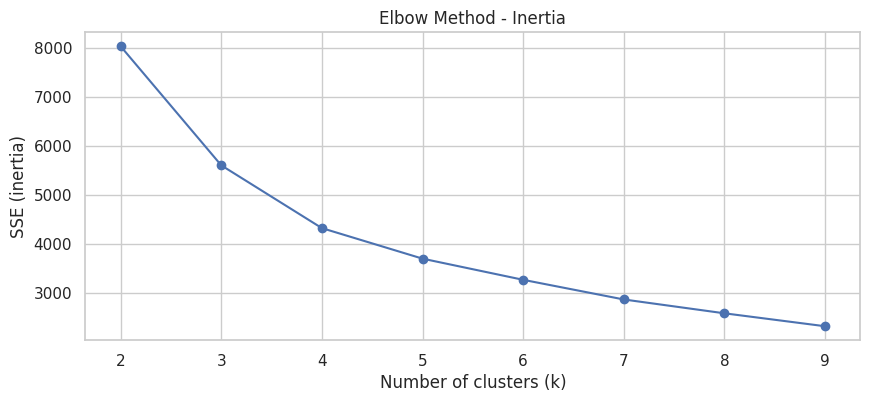

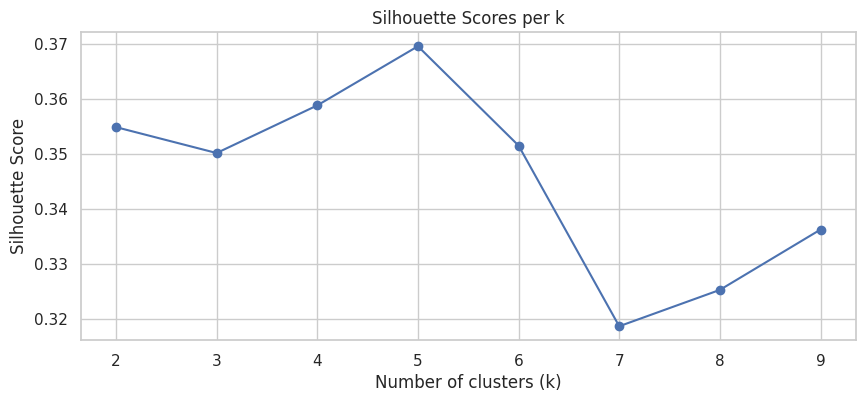

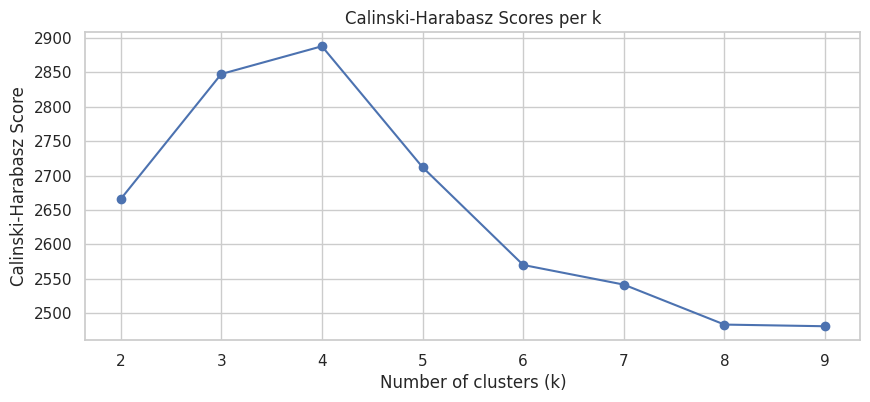


Tabel hasil evaluasi K-Means:
   SSE_inertia  Silhouette  Calinski_Harabasz
k                                            
2  8031.309560    0.354819        2665.553846
3  5602.301253    0.350110        2847.535687
4  4321.105147    0.358768        2887.908079
5  3698.289287    0.369516        2712.056345
6  3266.643104    0.351462        2569.961566
7  2865.745761    0.318631        2541.404577
8  2583.408963    0.325238        2483.305975
9  2319.545327    0.336204        2480.886124


In [ ]:
sse = []
silhouette_scores = []
ch_scores = []

ks = range(2, 10)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(rfm_scaled)

    # SSE / inertia
    sse.append(km.inertia_)

    # Silhouette
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

    # Calinski–Harabasz
    ch_scores.append(calinski_harabasz_score(rfm_scaled, labels))

# === Plot ===
plt.figure(figsize=(10,4))
plt.plot(ks, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (inertia)')
plt.title('Elbow Method - Inertia')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(ks, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores per k')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(ks, ch_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Scores per k')
plt.grid(True)
plt.show()

# === tabel evaluasi ===
eval_df = pd.DataFrame({
    'k': list(ks),
    'SSE_inertia': sse,
    'Silhouette': silhouette_scores,
    'Calinski_Harabasz': ch_scores
})

# index k
eval_df.set_index('k', inplace=True)

print("\nTabel hasil evaluasi K-Means:")
print(eval_df)

7. Clustering (K-means)

In [ ]:
k_final = 4
kmeans_final = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans_final.fit_predict(rfm_scaled)

# Simpan ke dataframe RFM asli
rfm['cluster'] = cluster_labels

print("Jumlah member per cluster:")
print(rfm['cluster'].value_counts().sort_index())

print("\nProfil RFM per cluster:")
cluster_profile = rfm.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'count'])
print(cluster_profile)

Jumlah member per cluster:
cluster
0    1156
1    1143
2     593
3    1435
Name: count, dtype: int64

Profil RFM per cluster:
            Recency              Frequency                  Monetary          \
               mean median count      mean median count         mean  median   
cluster                                                                        
0        773.509516  759.0  1156  1.426471    1.0  1156   913.562284   596.0   
1        216.594926  180.0  1143  3.634296    3.0  1143  1732.223097  1623.0   
2        266.674536  220.0   593  3.224283    3.0   593  5363.885329  4995.0   
3        240.770035  239.0  1435  1.592334    2.0  1435   859.909408   646.0   

               
        count  
cluster        
0        1156  
1        1143  
2         593  
3        1435  


8. Evaluasi hasil k-means

In [ ]:
# X = data yang digunakan k-means
X = rfm_scaled
labels = rfm['cluster'].values

# skor evaluasi global
sil_global = silhouette_score(X, labels)
ch_score   = calinski_harabasz_score(X, labels)
db_score   = davies_bouldin_score(X, labels)

print("=== Evaluasi K-Means (k = {}) ===".format(k_final))
print("Silhouette score (global)            :", sil_global)
print("Calinski-Harabasz score              :", ch_score)
print("Davies-Bouldin index (lower=better)  :", db_score)

# --- silhouette per titik & per cluster ---
rfm['silhouette'] = silhouette_samples(X, labels)
sil_per_cluster = rfm.groupby('cluster')['silhouette'].mean()

print("\nRata-rata silhouette per cluster:")
print(sil_per_cluster)

# ========== evaluasi global  ==========
eval_global_df = pd.DataFrame({
    'k': [k_final],
    'Silhouette_global': [sil_global],
    'Calinski_Harabasz': [ch_score],
    'Davies_Bouldin': [db_score]
}).set_index('k')

print("\nTabel evaluasi global K-Means:")
print(eval_global_df.round(4))

# ========== evaluasi per cluster ==========
cluster_eval_df = rfm.groupby('cluster').agg(
    Num_Customers   = ('CustomerID', 'count'),
    Recency_mean    = ('Recency', 'mean'),
    Frequency_mean  = ('Frequency', 'mean'),
    Monetary_mean   = ('Monetary', 'mean'),
    Silhouette_mean = ('silhouette', 'mean')
).reset_index()

print("\nTabel evaluasi per cluster:")
print(cluster_eval_df.round(3))



=== Evaluasi K-Means (k = 4) ===
Silhouette score (global)            : 0.35876787033163604
Calinski-Harabasz score              : 2887.908079293181
Davies-Bouldin index (lower=better)  : 0.9985385738371675

Rata-rata silhouette per cluster:
cluster
0    0.392256
1    0.296189
2    0.237517
3    0.431741
Name: silhouette, dtype: float64

Tabel evaluasi global K-Means:
   Silhouette_global  Calinski_Harabasz  Davies_Bouldin
k                                                      
4             0.3588          2887.9081          0.9985

Tabel evaluasi per cluster:
   cluster  Num_Customers  Recency_mean  Frequency_mean  Monetary_mean  \
0        0           1156       773.510           1.426        913.562   
1        1           1143       216.595           3.634       1732.223   
2        2            593       266.675           3.224       5363.885   
3        3           1435       240.770           1.592        859.909   

   Silhouette_mean  
0            0.392  
1            0.296 

9. Analisis dan Interpretasi Cluster

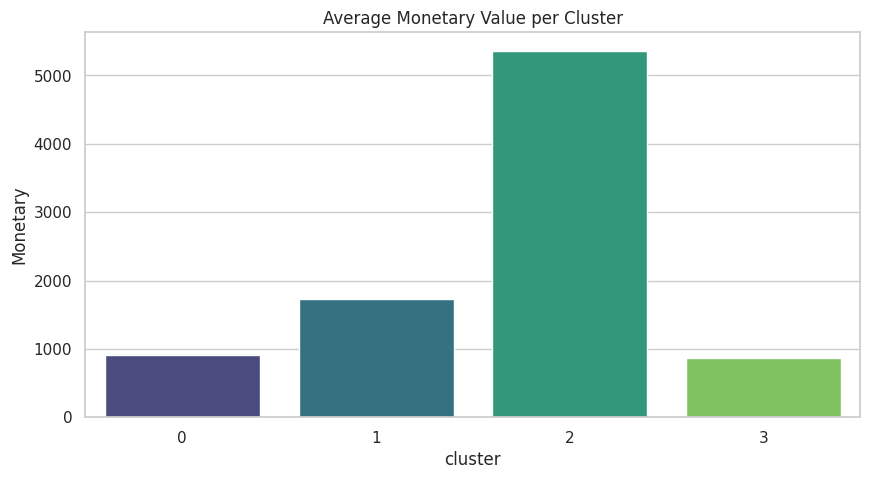

   cluster  Num_Customers  Total_Revenue  Share_Customers  Share_Revenue
0        0           1156        1056078            0.267          0.142
1        1           1143        1979931            0.264          0.266
2        2            593        3180784            0.137          0.427
3        3           1435        1233970            0.332          0.166


In [ ]:
rfm_group = rfm.groupby('cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'CustomerID':'count'
}).rename(columns={'CustomerID':'Num_Customers'}).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=rfm_group, x='cluster', y='Monetary', palette='viridis')
plt.title('Average Monetary Value per Cluster')
plt.show()

rev_cluster = rfm.groupby('cluster').agg(
    Num_Customers=('CustomerID', 'count'),
    Total_Revenue=('Monetary', 'sum')
).reset_index()

rev_cluster['Share_Customers'] = rev_cluster['Num_Customers'] / rev_cluster['Num_Customers'].sum()
rev_cluster['Share_Revenue']   = rev_cluster['Total_Revenue'] / rev_cluster['Total_Revenue'].sum()

print(rev_cluster.round(3))



10. Labelisasi Segmen Pelanggan

In [ ]:
# Hitung jumlah cluster
n_clusters = rfm['cluster'].nunique()
print("Number of clusters detected:", n_clusters)

# Default: generic label per cluster
segment_map = {c: f'Segment_{c}' for c in sorted(rfm['cluster'].unique())}

if n_clusters == 4:
    segment_map = {
        0: 'Lost / Dormant Low-Value',
        1: 'Loyal Mid-Value Customers',
        2: 'High-Value / VIP Customers',
        3: 'Occasional Low-Value Customers'
    }

# Map cluster ke segment name
rfm['Segment'] = rfm['cluster'].map(segment_map)

rfm.head()



Number of clusters detected: 4


,CustomerID,Recency,Monetary,Frequency,cluster,silhouette,Segment
0,CUST1000,238,6336,5,2,0.323334,High-Value / VIP Customers
1,CUST1001,139,690,2,3,0.503246,Occasional Low-Value Customers
2,CUST1002,1020,999,1,0,0.577328,Lost / Dormant Low-Value
3,CUST1003,604,444,2,0,0.227273,Lost / Dormant Low-Value
4,CUST1004,223,796,1,3,0.592902,Occasional Low-Value Customers


11. Visualisasi Distribusi Segmen

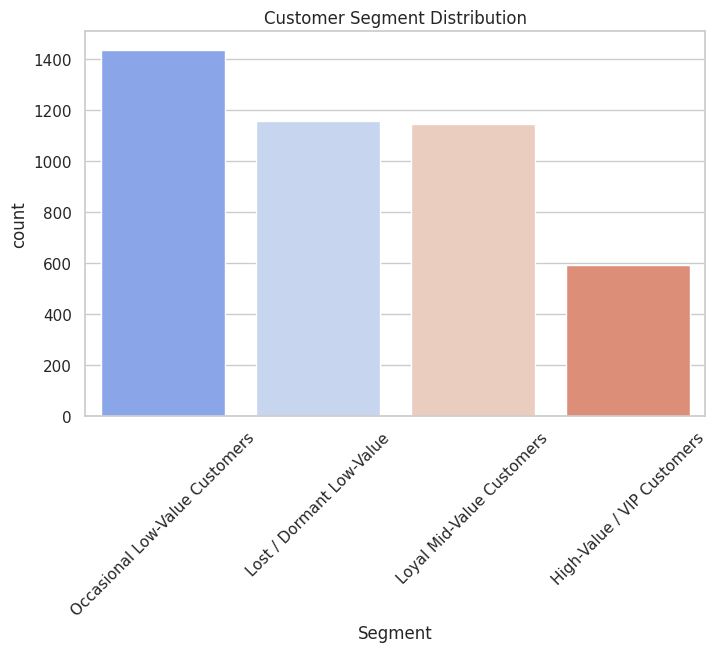

In [ ]:
plt.figure(figsize=(8,5))
order = rfm['Segment'].value_counts().index
sns.countplot(data=rfm, x='Segment', order=order, palette='coolwarm')
plt.title('Customer Segment Distribution')
plt.xticks(rotation=45)
plt.show()

| Segment                            | Karakteristik Utama                                                                                               | Strategi Marketing Utama                                                                                                                                    |
| ---------------------------------- | ----------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **High-Value / VIP Customers**     | 13.7% pelanggan, kontribusi 42.7% revenue. Recency rendah–sedang, Frequency tinggi, Monetary **sangat tinggi**. | Pertahankan & upgrade: program VIP/loyalty eksklusif, personal account manager, early access produk, special promo & priority support.                      |
| **Loyal Mid-Value Customers**      | 26% pelanggan & 27% revenue. Recency paling rendah, Frequency tertinggi, Monetary menengah.                     | Dorong naik kelas ke VIP: cross-sell/upsell, paket bundling, loyalty points, rekomendasi produk personal, email/newsletter rutin.                           |
| **Occasional Low-Value Customers** | 33% pelanggan tapi hanya 16.6% revenue. Recency sedang, Frequency rendah, Monetary rendah.                      | Aktivasi frekuensi: promo “buy more save more”, paket hemat, edukasi produk, reminder ringan (email/WA) untuk mendorong pembelian ulang.                    |
| **Lost / Dormant Low-Value**       | 26.7% pelanggan, hanya 14.2% revenue. Recency sangat tinggi (lama tidak beli), Frequency & Monetary rendah.     | Kampanye reaktivasi berbiaya rendah: win-back campaign, diskon besar satu kali, survey alasan berhenti; jika respon rendah, fokus dialihkan ke segmen lain. |


12. Konversi ke TensorFlow.js

In [ ]:
centroids = kmeans_final.cluster_centers_.tolist()

export_obj = {
    'centroids': centroids,
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist(),
    'feature_order': ['Recency', 'Frequency_log', 'Monetary_log']
}

with open('kmeans_centroids.json', 'w') as f:
    json.dump(export_obj, f)

print(rfm.columns)
print('cluster centers shape:', kmeans_final.cluster_centers_.shape)
print('scaler mean:', scaler.mean_)
print('Centroids + scaler saved to kmeans_centroids.json')


Index(['CustomerID', 'Recency', 'Monetary', 'Frequency', 'cluster',
       'silhouette', 'Segment'],
      dtype='object')
cluster centers shape: (4, 3)
scaler mean: [ 380.2606887     2.31107003 1721.92350358]
Centroids + scaler saved to kmeans_centroids.json


13. Simpan Hasil

In [ ]:
rfm.to_csv('rfm_cluster_result.csv', index=False)
print('Saved: rfm_cluster_result.csv (include Cluster & Segment columns)')

Saved: rfm_cluster_result.csv (include Cluster & Segment columns)
